# Health Insurance Price Prediction (Linear Regression)


## 1. Importing Libraries


In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('./data/Health_insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Our objective is to find a way to estimate the value in the "charges" column using the values in the other columns. If we can do so for the historical data, then we should able to estimate charges for new customers too, simply by asking for information like their age, sex, BMI, no. of children, smoking habits and region.


In [4]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


## 2. Exploratory Data Analysis


In [5]:
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

### Age

Age is a numeric column. The minimum age in the dataset is 18 and the maximum age is 64. Thus, we can visualize the distribution of age using a histogram with 47 bins (one for each year) and a box plot.


In [6]:
fig = px.histogram(df,
                   x='age',
                   marginal='box',
                   nbins=47,
                   title='Distribution of Age')
fig.update_layout(bargap=0.1)
fig.show()

The distribution of ages in the dataset is almost uniform, with 20-30 customers at every age, except for the ages 18 and 19, which seem to have over twice as many customers as other ages.

> Insight: why there are over twice as many customers with ages 18 and 19, compared to other ages?

> Insurance agency charges more money for same premium as you get older and here is the same case. People who are younger are less prone to getting sick and thus company has to pay them less for their medical bills.


### Body Mass Index


In [7]:
fig = px.histogram(df,
                   x='bmi',
                   marginal='box',
                   color_discrete_sequence=['red'],
                   title='Distribution of BMI (Body Mass Index)')
fig.update_layout(bargap=0.1)
fig.show()

The measurements of body mass index seem to form a Gaussian distribution centered around the value 30, with a few outliers towards the right.

> Insight: why the distribution of ages forms a uniform distribution while the distribution of BMIs forms a gaussian distribution?

> As there are same number of people in age groups the distribution we get is uniform distribution. But, for BMIs distribution we get gaussian distribution as people who are between 20-30 are considered to be healthy relatively and less than or more than this range is considered to be health risk categories and these people are more prone to health issues and thus company will have to pay more medical bills of this kind of customers and thus they provide these type of people same health insurance at higher prices and which in-turn attracts lesser people with out of healthy range BMI because they have to pay more.


### Charges


In [8]:
fig = px.histogram(df,
                   x='charges',
                   marginal='box',
                   color='smoker',
                   color_discrete_sequence=['red', 'grey'],
                   title='Annual Medical Charges')
fig.update_layout(bargap=0.1)
fig.show()

- For most customers, the annual medical charges are under $10,000. Only a small fraction of customer have higher medical expenses, possibly due to accidents, major illnesses and genetic diseases. The distribution follows a "power law"

- There is a significant difference in medical expenses between smokers and non-smokers. While the median for non-smokers is $7300, the median for smokers is close to \$35,000.


In [9]:
fig = px.histogram(df,
                   x='charges',
                   color='sex',
                   color_discrete_sequence=["blue", "red"],
                   title='Different charges over genders'

                   )
fig.update_layout(bargap=0.1)
fig.show()

In [10]:
fig = px.histogram(df,
                   x="charges",
                   marginal='box',
                   color="region",
                   title="charges over different regions of U.S.A")
fig.update_layout(bargap=0.1)
fig.show()

Here in the distribution of charges over gender we see that males are substantially charged more because by subconscious behavior males are exploratory and they are more likely to take risks and that keeps them in danger more than their counterpart.


### Smoker


In [11]:
df.smoker.value_counts()

smoker
no     1064
yes     274
Name: count, dtype: int64

In [12]:
px.histogram(df, x='smoker', color='sex', title='Smoker')

Smoking appears a more common habit among males.


### Correlation Heatmap


Text(0.5, 1.0, 'Correlation Heatmap')

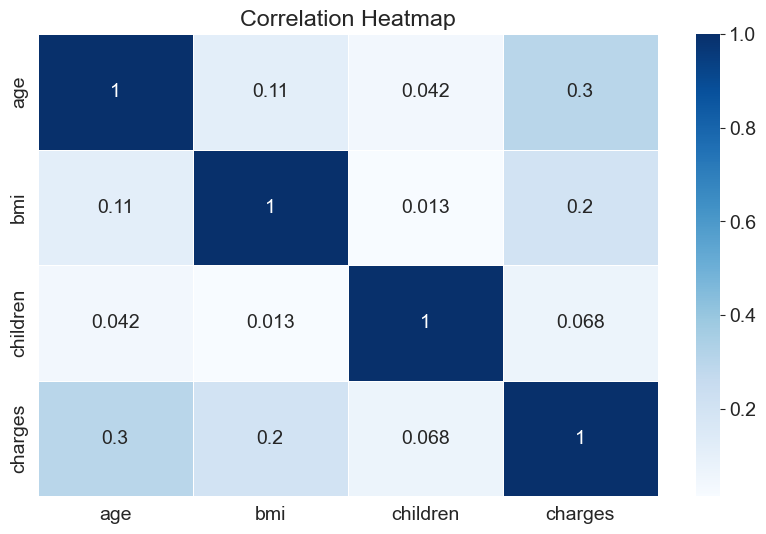

In [13]:
numeric_df = df.select_dtypes(include=[np.number])

sns.heatmap(numeric_df.corr(), annot=True, cmap='Blues', linewidths=0.5)
plt.title('Correlation Heatmap')

## 3. PySpark


In [14]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

In [15]:
spark = SparkSession.builder.appName(
    "health_insurance_prediction").getOrCreate()
spark

In [16]:
spark_df = spark.read.csv('./data/Health_insurance.csv', header=True, inferSchema=True)
spark_df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- children: integer (nullable = true)
 |-- smoker: string (nullable = true)
 |-- region: string (nullable = true)
 |-- charges: double (nullable = true)



In [17]:
spark_df.show(5)

+---+------+------+--------+------+---------+-----------+
|age|   sex|   bmi|children|smoker|   region|    charges|
+---+------+------+--------+------+---------+-----------+
| 19|female|  27.9|       0|   yes|southwest|  16884.924|
| 18|  male| 33.77|       1|    no|southeast|  1725.5523|
| 28|  male|  33.0|       3|    no|southeast|   4449.462|
| 33|  male|22.705|       0|    no|northwest|21984.47061|
| 32|  male| 28.88|       0|    no|northwest|  3866.8552|
+---+------+------+--------+------+---------+-----------+
only showing top 5 rows



In [18]:
# Feature Engineering: Convert categorical columns to numerical using StringIndexer
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(spark_df)
            for column in ["sex", "smoker", "region"]]
pipeline = Pipeline(stages=indexers)
spark_df = pipeline.fit(spark_df).transform(spark_df)

In [19]:
spark_df.show(5)

+---+------+------+--------+------+---------+-----------+---------+------------+------------+
|age|   sex|   bmi|children|smoker|   region|    charges|sex_index|smoker_index|region_index|
+---+------+------+--------+------+---------+-----------+---------+------------+------------+
| 19|female|  27.9|       0|   yes|southwest|  16884.924|      1.0|         1.0|         2.0|
| 18|  male| 33.77|       1|    no|southeast|  1725.5523|      0.0|         0.0|         0.0|
| 28|  male|  33.0|       3|    no|southeast|   4449.462|      0.0|         0.0|         0.0|
| 33|  male|22.705|       0|    no|northwest|21984.47061|      0.0|         0.0|         1.0|
| 32|  male| 28.88|       0|    no|northwest|  3866.8552|      0.0|         0.0|         1.0|
+---+------+------+--------+------+---------+-----------+---------+------------+------------+
only showing top 5 rows



In [20]:
# Assemble features into a vector
feature_cols = ["age", "sex_index", "bmi", "children", "smoker_index", "region_index"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_df = assembler.transform(spark_df)

In [21]:
# Split the dataset into training and testing sets
(train_data, test_data) = assembled_df.randomSplit([0.8, 0.2], seed=42)

In [22]:
# Create a Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="charges")

# Fit the model using the training data
lr_model = lr.fit(train_data)

In [23]:
# Make predictions on the test data
predictions = lr_model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="charges", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = {:.2f}".format(rmse))

# Display the coefficients and intercept of the model
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))


Root Mean Squared Error (RMSE) on test data = 5675.91
Coefficients: [252.32119137830554,225.54421946089332,351.7663044406283,528.3938115309102,23518.467094898115,285.79456481699503]
Intercept: -13298.245606940274


In [24]:
# Close the Spark session
spark.stop()